## EXPLORATORY ANALYSIS OF DATA

In [1]:
#!pip install wordcloud

In [2]:
#!pip install nltk

In [3]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.model_selection import train_test_split, cross_validate
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords 
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import layers, Sequential
from sklearn.linear_model import PassiveAggressiveClassifier
import joblib

2023-02-20 15:28:06.632830: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-20 15:28:06.773193: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-02-20 15:28:06.780022: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-20 15:28:06.780046: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore 

In [4]:
#downloading the data
og_data = pd.read_csv("../raw_data/dataset.csv")
og_data.head()

,Unnamed: 0,title,text,label
0,0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1
1,1,NaN,Did they post their votes for Hillary already?,1
2,2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1
3,3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0
4,4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1


In [5]:
#getting a quick sense of the data

print(f"Shape: {og_data.shape[0]} rows, {og_data.shape[1]} columns \n")
print(f"Info in columns: \n")
print(f"{og_data.info()} \n")
print(f"Null values per column: \n\n {og_data.isnull().sum()}")

Shape: 72134 rows, 4 columns 

Info in columns: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72134 entries, 0 to 72133
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  72134 non-null  int64 
 1   title       71576 non-null  object
 2   text        72095 non-null  object
 3   label       72134 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 2.2+ MB
None 

Null values per column: 

 Unnamed: 0      0
title         558
text           39
label           0
dtype: int64


In [6]:
#There are a few null lines. Let's get rid of them:

data = og_data.dropna()
data.reset_index(inplace=True)

#Also there's a useless column, we don't need it:

data = data[["title", "text", "label"]]

print(f"final data shape: {data.shape}")

final data shape: (71537, 3)


## DATA VISUALIZATION

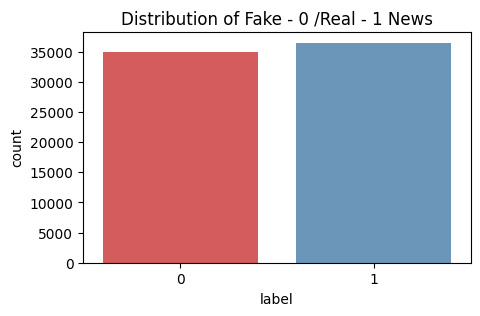

In [7]:
#Are the two categories well-balanced in this dataset?

plt.figure(figsize = (5,3))
sns.countplot(x = data['label'], palette = 'Set1', alpha = 0.8)
plt.title('Distribution of Fake - 0 /Real - 1 News');

/tmp/ipykernel_7222/2458238716.py:5: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data['title_num_words'], bins = range(1, 50), palette = 'Set1', alpha = 0.8)


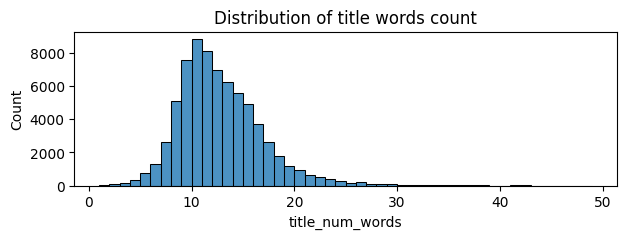

In [8]:
#How many words do the titles have?

data["title_num_words"] = [len(ti.split()) for ti in data.title]
plt.figure(figsize = (7,2))
sns.histplot(data['title_num_words'], bins = range(1, 50), palette = 'Set1', alpha = 0.8)
plt.title('Distribution of title words count');

/tmp/ipykernel_7222/3159653495.py:5: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data['text_num_words'], bins = range(1, 7000, 100), palette = 'Set1', alpha = 0.8)


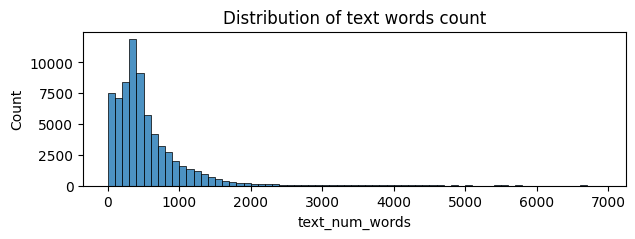

In [9]:
#How many words do the texts have?

data["text_num_words"] = [len(ti.split()) for ti in data.text]
plt.figure(figsize = (7,2))
sns.histplot(data['text_num_words'], bins = range(1, 7000, 100), palette = 'Set1', alpha = 0.8)
plt.title('Distribution of text words count');

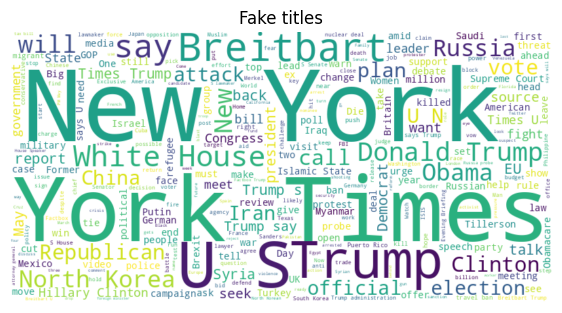

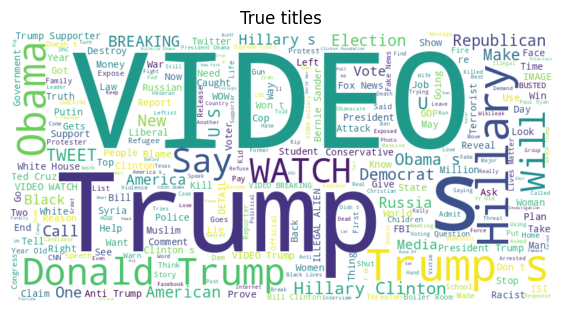

In [10]:
#We will check the most common words in fake titles vs true titles:

fake_news = data[data["label"] == 0]

fake_titles = ' '.join(title for title in fake_news['title'])

wordcloud = WordCloud(
    background_color='white', 
    stopwords=STOPWORDS, 
    max_words=300,
    width=800, 
    height=400,
).generate(fake_titles)

plt.figure(figsize=(7, 4))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Fake titles")
plt.show()

true_news = data[data["label"] == 1]

true_titles = ' '.join(title for title in true_news['title'])

wordcloud = WordCloud(
    background_color='white', 
    stopwords=STOPWORDS, 
    max_words=300,
    width=800, 
    height=400,
).generate(true_titles)

plt.figure(figsize=(7, 4))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("True titles")
plt.show()

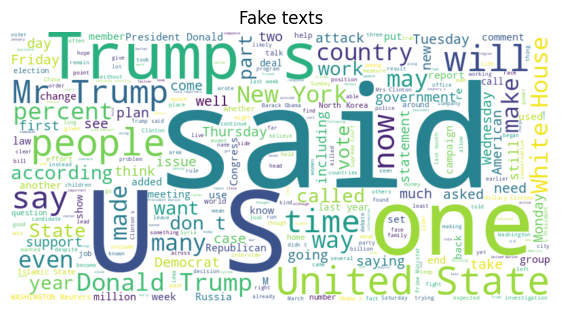

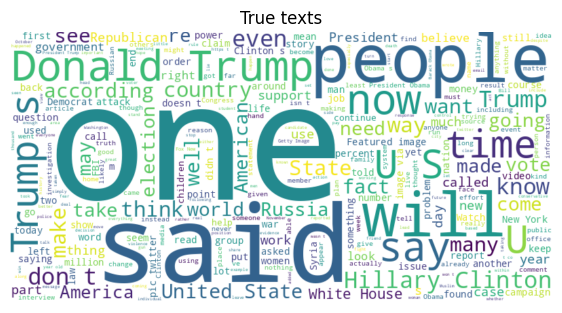

In [11]:
#Let's do the same but for texts:


fake_texts = ' '.join(title for title in fake_news['text'])

wordcloud = WordCloud(
    background_color='white', 
    stopwords=STOPWORDS, 
    max_words=300,
    width=800, 
    height=400,
).generate(fake_texts)

plt.figure(figsize=(7, 4))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Fake texts")
plt.show()


true_texts = ' '.join(title for title in true_news['text'])

wordcloud = WordCloud(
    background_color='white', 
    stopwords=STOPWORDS, 
    max_words=300,
    width=800, 
    height=400,
).generate(true_texts)

plt.figure(figsize=(7, 4))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("True texts")
plt.show()

## PREDICTING USING TITLES

### TEXT PROCESSING

In [12]:
#Get the independent features:

X = data.drop(columns = ["label", "title_num_words", "text_num_words"])

#Get the dependent variables:

y = data["label"]

In [13]:
#Specifying an X for title

X_title = X.drop("text", axis=1)

In [14]:
#Preprocessing the titles

def preprocess_text(text):
    
    #removing excess space
    text = text.strip()
    
    #making sure texts are lowercase
    text = text.lower()
    
    #removing digits
    text = "".join(char for char in text if not char.isdigit())
    
    #removing punctuation and symbols
    for punctuation in string.punctuation:
        text = text.replace(punctuation,"")
    
    #tokenizing
    text = word_tokenize(text)
    
    #removing stopwords
    stop_words = set(stopwords.words('english'))
    
    text = [w for w in text if not w in stop_words]
    
    #lemmatizing verbs and nouns
    text = [WordNetLemmatizer().lemmatize(w, pos = "v") for w in text]
    text = [WordNetLemmatizer().lemmatize(w, pos = "n") for w in text]
    
    #converting tokens to string again
    text = " ".join(text)
    
    return text

In [15]:
X_title_preprocessed = [preprocess_text(title) for title in X_title.title]

In [16]:
# doing the train_test_split

X_title_train, X_title_test, y_title_train, y_title_test = train_test_split(X_title_preprocessed, y)

### SETTING LOGISTIC REGRESSION AS A BASELINE

In [17]:
#use bag of words to represent the titles

countvectorizer = CountVectorizer()
bow_transformer = countvectorizer.fit(X_title_train)
text_bow_train = bow_transformer.transform(X_title_train)
text_bow_test = bow_transformer.transform(X_title_test)

In [18]:
lr_classifier = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg', 
                         multi_class='multinomial', random_state=40)

In [19]:
bow = dict()

bow["train"] = (text_bow_train, y_title_train)
bow["test"] = (text_bow_test, y_title_test)


embedding = bow
classifier = lr_classifier 

In [20]:
classifier.fit(*embedding["train"])
y_predict = classifier.predict(embedding["test"][0])

In [21]:
def get_metrics(y_test, y_predicted):  
    # true positives / (true positives+false positives)
    precision = precision_score(y_test, y_predicted, pos_label=None,
                                    average='weighted')             
    # true positives / (true positives + false negatives)
    recall = recall_score(y_test, y_predicted, pos_label=None,
                              average='weighted')
    
    # harmonic mean of precision and recall
    f1 = f1_score(y_test, y_predicted, pos_label=None, average='weighted')
    
    # true positives + true negatives/ total
    accuracy = accuracy_score(y_test, y_predicted)
    return accuracy, precision, recall, f1


In [22]:
accuracy, precision, recall, f1 = get_metrics(embedding["test"][1], y_predict)
print("accuracy = %.5f, precision = %.5f, recall = %.5f, f1 = %.5f" % (accuracy, precision, recall, f1))

accuracy = 0.88929, precision = 0.88933, recall = 0.88929, f1 = 0.88928


### TRYING NAIVE BAYES CLASSIFIER

In [23]:
nb_classifier = MultinomialNB()

In [24]:
nb_classifier.fit(text_bow_train, y_title_train)

MultinomialNB()

In [25]:
predictions_nb = nb_classifier.predict(text_bow_test)

In [26]:
accuracy_nb, precision_nb, recall_nb, f1_nb = get_metrics(embedding["test"][1], predictions_nb)
print("accuracy = %.5f, precision = %.5f, recall = %.5f, f1 = %.5f" % (accuracy_nb, precision_nb, recall_nb, f1_nb))

accuracy = 0.88141, precision = 0.88143, recall = 0.88141, f1 = 0.88141


### TRYING PASSIVE-AGRESSIVE CLASSIFIER

In [27]:
linear_clf = PassiveAggressiveClassifier(max_iter=50)
linear_clf.fit(text_bow_train,y_title_train)

PassiveAggressiveClassifier(max_iter=50)

In [28]:
pred = linear_clf.predict(text_bow_test)


In [29]:
accuracy_passive, precision_passive, recall_passive, f1_passive = get_metrics(embedding["test"][1], pred)
print("accuracy = %.5f, precision = %.5f, recall = %.5f, f1 = %.5f" % (accuracy_passive, precision_passive, recall_passive, f1_passive))

accuracy = 0.87587, precision = 0.87612, recall = 0.87587, f1 = 0.87582


### TRYING A RANDOM FOREST CLASSIFICATOR

In [30]:
# cross validating a random forest classifier

model_forest = RandomForestClassifier(n_estimators=300)

scores_forest = cross_validate(model_forest, text_bow_train, y_title_train, scoring=['f1', 'accuracy', "recall", "precision"], cv=5, n_jobs=-1)
pd.DataFrame(scores_forest).describe()

,fit_time,score_time,test_f1,test_accuracy,test_recall,test_precision
count,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
mean,462.584170,2.703084,0.896528,0.892567,0.910848,0.882673
std,1.812913,0.386889,0.003772,0.004053,0.004632,0.005702
min,460.821515,2.077863,0.890878,0.886404,0.907151,0.874824
25%,460.980221,2.689632,0.895557,0.891333,0.907532,0.879951
50%,462.819895,2.698911,0.896278,0.892731,0.909356,0.883044
75%,463.029288,3.002058,0.899513,0.896179,0.911727,0.885663
max,465.269931,3.046955,0.900411,0.896189,0.918475,0.889880


In [31]:
# a bit better than the baseline. let's actually train the model

model_forest.fit(text_bow_train, y_title_train)

y_pred_forest= model_forest.predict(text_bow_test)

In [32]:
accuracy_forest, precision_forest, recall_forest, f1_forest = get_metrics(embedding["test"][1], y_pred_forest)
print("accuracy = %.5f, precision = %.5f, recall = %.5f, f1 = %.5f" % (accuracy_forest, precision_forest, recall_forest, f1_forest))

accuracy = 0.89969, precision = 0.90027, recall = 0.89969, f1 = 0.89962


### TRYING A LTSM  RNN

In [33]:
tk = Tokenizer()

In [34]:
tk.fit_on_texts(X_title_train)

In [35]:
vocab_size = len(tk.word_index)
print(f'There are {vocab_size} different words in my corpus')

There are 25253 different words in my corpus


In [36]:
X_token = tk.texts_to_sequences(X_title_train)
X_token_test = tk.texts_to_sequences(X_title_test)

In [37]:
X_pad = pad_sequences(X_token, dtype='float32', padding='post')
X_pad_test = pad_sequences(X_token_test, dtype='float32', padding='post')

In [38]:
embedding_size = 100

model = Sequential()

model.add(layers.Embedding(
    input_dim=vocab_size+1, # +1 for the 0 padding
    #input_length=, # Max_sentence_length
    output_dim=embedding_size, # 100
    mask_zero=True, # Built-in masking layer :)
))

model.add(layers.LSTM(20))
model.add(layers.Dense(1, activation="sigmoid"))
model.summary()

2023-02-20 15:42:32.382639: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-02-20 15:42:32.385621: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-02-20 15:42:32.386782: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (DESKTOP-E4B70IE): /proc/driver/nvidia/version does not exist
2023-02-20 15:42:32.403044: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 100)         2525400   
                                                                 
 lstm (LSTM)                 (None, 20)                9680      
                                                                 
 dense (Dense)               (None, 1)                 21        
                                                                 
Total params: 2,535,101
Trainable params: 2,535,101
Non-trainable params: 0
_________________________________________________________________


In [39]:
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [40]:
history_tk = model.fit(X_pad, y_title_train, epochs=5, batch_size=16, verbose=1)

Epoch 1/5
3354/3354 [==============================] - 83s 23ms/step - loss: 0.2753 - accuracy: 0.8834
Epoch 2/5
3354/3354 [==============================] - 89s 27ms/step - loss: 0.2046 - accuracy: 0.9184
Epoch 3/5
3354/3354 [==============================] - 86s 26ms/step - loss: 0.1687 - accuracy: 0.9347
Epoch 4/5
3354/3354 [==============================] - 88s 26ms/step - loss: 0.1417 - accuracy: 0.9473
Epoch 5/5
3354/3354 [==============================] - 89s 26ms/step - loss: 0.1218 - accuracy: 0.9555


In [41]:
test_loss, test_acc = model.evaluate(X_pad_test, embedding["test"][1])
predictions_tk = model.predict(X_pad_test)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

559/559 [==============================] - 4s 5ms/step
Test Loss: 0.208413228392601
Test Accuracy: 0.9240145087242126


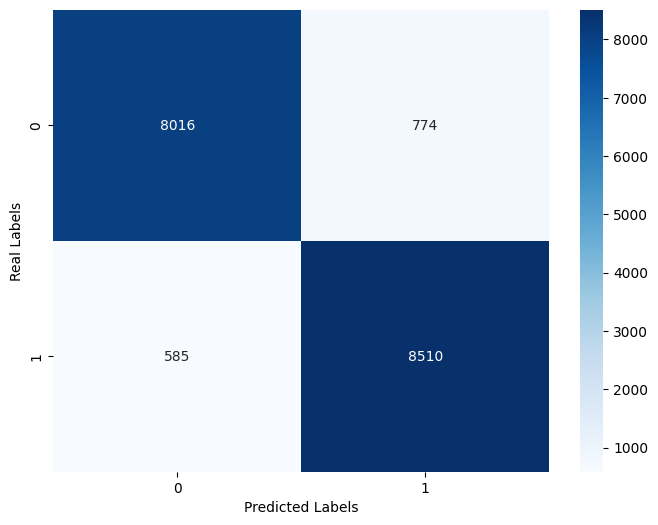

In [42]:
plt.figure(figsize = (8,6))

sns.heatmap(confusion_matrix(embedding["test"][1], np.where(predictions_tk >= 0.5, 1, 0)), annot=True, 
            fmt='', cmap='Blues')

plt.xlabel('Predicted Labels')
plt.ylabel('Real Labels');

In [43]:
model.save("fakenews_model")

INFO:tensorflow:Assets written to: fakenews_model/assets


INFO:tensorflow:Assets written to: fakenews_model/assets


In [44]:
new_title = "Unbelievable! Donald Trump was born in HAWAII"

In [45]:
title_preprocessed = preprocess_text(new_title)

In [46]:
title_preprocessed_token = tk.texts_to_sequences([title_preprocessed])
title_preprocessed_token

[[2431, 21, 2, 1309, 2315]]

In [47]:
trying_a_ting = model.predict(title_preprocessed_token)
trying_a_ting

1/1 [==============================] - 1s 1s/step


array([[0.42709675]], dtype=float32)

In [48]:
title_pad = pad_sequences(title_preprocessed_token, dtype='float32', padding='post')

In [49]:
title_pad

array([[2.431e+03, 2.100e+01, 2.000e+00, 1.309e+03, 2.315e+03]],
      dtype=float32)

In [50]:
predictions_tk_bis = model.predict(title_pad)
predictions_tk_bis

1/1 [==============================] - 1s 700ms/step


array([[0.42709675]], dtype=float32)

In [51]:
figuring_out = model.predict(X_pad_test)
figuring_out

559/559 [==============================] - 3s 6ms/step


array([[8.6422004e-03],
       [9.7071099e-01],
       [8.7208668e-04],
       ...,
       [6.8122596e-03],
       [4.0965173e-01],
       [9.9896574e-01]], dtype=float32)

In [52]:
predictions_tk_bis[0][0]

0.42709675

In [53]:
figuring_out[0][0]

0.0086422

## (NOT NECESSARY) PREDICTING USING TEXT INSTEAD OF TITLE

In [54]:
#X_text = X.drop("title", axis=1)

In [55]:
#X_text_preprocessed = [preprocess_text(text) for text in X_text.text]

In [56]:
# doing the train_test_split

#X_text_train, X_text_test, y_text_train, y_text_test = train_test_split(X_text_preprocessed, y)

In [57]:
#tk_text = Tokenizer()

In [58]:
#tk_text.fit_on_texts(X_text_train)

In [59]:
#vocab_size_text = len(tk_text.word_index)
#print(f'There are {vocab_size_text} different words in my corpus')

In [60]:
#X_token_text = tk_text.texts_to_sequences(X_text_train)
#X_token_test_text = tk.texts_to_sequences(X_text_test)

In [61]:
#X_pad_text = pad_sequences(X_token_text, dtype='float32', padding='post')
#X_pad_test_text = pad_sequences(X_token_test_text, dtype='float32', padding='post')

In [62]:
#embedding_size = 100

#model_text = Sequential()

#model_text.add(layers.Embedding(
#    input_dim=vocab_size_text+1, # +1 for the 0 padding
#    #input_length=, # Max_sentence_length
#    output_dim=embedding_size, # 100
#    mask_zero=True, # Built-in masking layer :)
#))

#model_text.add(layers.LSTM(20))
#model_text.add(layers.Dense(1, activation="sigmoid"))
#model_text.summary()

In [63]:
#model_text.compile(loss='binary_crossentropy',
#              optimizer='rmsprop',
#              metrics=['accuracy'])

In [64]:
#history_tk_text = model_text.fit(X_pad_text, y_text_train, epochs=5, batch_size=32, verbose=1)

test_loss_text, test_acc_text = model_text.evaluate(X_pad_test_text, embedding["test"][1])
predictions_tk_text = model_text.predict(X_pad_test_text)

print('Test Loss:', test_loss_text)
print('Test Accuracy:', test_acc_text)

##### plt.figure(figsize = (8,6))

sns.heatmap(confusion_matrix(embedding["test"][1], np.where(predictions_tk_text >= 0.5, 1, 0)), annot=True, 
            fmt='', cmap='Blues')

plt.xlabel('Predicted Labels')
plt.ylabel('Real Labels');

##### plt.figure(figsize = (8,6))

sns.heatmap(confusion_matrix(embedding["test"][1], np.where(predictions_tk_text >= 0.5, 1, 0)), annot=True, 
            fmt='', cmap='Blues')

plt.xlabel('Predicted Labels')
plt.ylabel('Real Labels');

##### plt.figure(figsize = (8,6))

sns.heatmap(confusion_matrix(embedding["test"][1], np.where(predictions_tk_text >= 0.5, 1, 0)), annot=True, 
            fmt='', cmap='Blues')

plt.xlabel('Predicted Labels')
plt.ylabel('Real Labels');

##### plt.figure(figsize = (8,6))

sns.heatmap(confusion_matrix(embedding["test"][1], np.where(predictions_tk_text >= 0.5, 1, 0)), annot=True, 
            fmt='', cmap='Blues')

plt.xlabel('Predicted Labels')
plt.ylabel('Real Labels');

##### plt.figure(figsize = (8,6))

sns.heatmap(confusion_matrix(embedding["test"][1], np.where(predictions_tk_text >= 0.5, 1, 0)), annot=True, 
            fmt='', cmap='Blues')

plt.xlabel('Predicted Labels')
plt.ylabel('Real Labels');

##### plt.figure(figsize = (8,6))

sns.heatmap(confusion_matrix(embedding["test"][1], np.where(predictions_tk_text >= 0.5, 1, 0)), annot=True, 
            fmt='', cmap='Blues')

plt.xlabel('Predicted Labels')
plt.ylabel('Real Labels');

##### plt.figure(figsize = (8,6))

sns.heatmap(confusion_matrix(embedding["test"][1], np.where(predictions_tk_text >= 0.5, 1, 0)), annot=True, 
            fmt='', cmap='Blues')

plt.xlabel('Predicted Labels')
plt.ylabel('Real Labels');

##### plt.figure(figsize = (8,6))

sns.heatmap(confusion_matrix(embedding["test"][1], np.where(predictions_tk_text >= 0.5, 1, 0)), annot=True, 
            fmt='', cmap='Blues')

plt.xlabel('Predicted Labels')
plt.ylabel('Real Labels');

##### plt.figure(figsize = (8,6))

sns.heatmap(confusion_matrix(embedding["test"][1], np.where(predictions_tk_text >= 0.5, 1, 0)), annot=True, 
            fmt='', cmap='Blues')

plt.xlabel('Predicted Labels')
plt.ylabel('Real Labels');

In [65]:
true_news['title']

0        LAW ENFORCEMENT ON HIGH ALERT Following Threat...
1        UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...
3        SATAN 2: Russia unvelis an image of its terrif...
4        About Time! Christian Group Sues Amazon and SP...
5        DR BEN CARSON TARGETED BY THE IRS: “I never ha...
                               ...                        
71528    WOW! JILL STEIN’S ‘FIRESIDE CHAT’ Exposes Her ...
71530    WIKILEAKS EMAIL SHOWS CLINTON FOUNDATION FUNDS...
71531    JUDGE JEANINE SOUNDS FREE SPEECH ALARM: “They ...
71533     WATCH: Giuliani Demands That Democrats Apolog...
71536    Goldman Sachs Endorses Hillary Clinton For Pre...
Name: title, Length: 36509, dtype: object

In [66]:
fake_news['title']

2        Bobby Jindal, raised Hindu, uses story of Chri...
10       May Brexit offer would hurt, cost EU citizens ...
11       Schumer calls on Trump to appoint official to ...
13       No Change Expected for ESPN Political Agenda D...
14       Billionaire Odebrecht in Brazil scandal releas...
                               ...                        
71527    An Unlikely Contender Rises in France as the A...
71529    Determined to kill: Can tough gun laws end mas...
71532    Russians steal research on Trump in hack of U....
71534    Migrants Refuse To Leave Train At Refugee Camp...
71535    Trump tussle gives unpopular Mexican leader mu...
Name: title, Length: 35028, dtype: object

In [67]:
joblib.dump(model, "model_for_deployment")

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......dense
.........vars
............0
............1
......embedding
.........vars
............0
......lstm
.........cell
............vars
...............0
...............1
...............2
.........vars
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
...optimizer
......vars
.........0
.........1
.........2
.........3
.........4
.........5
.........6
...vars
Keras model archive saving:
File Name                                             Modified             Size
metadata.json                                  2023-02-20 15:50:30           64
config.json                                    2023-02-20 15:50:30         2210
variables.h5                                   2023-02-20 15:50:30     20305376


['model_for_deployment']